In [1]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
! pip install segmentation_models 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 


In [3]:
## Importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import os
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array 
import segmentation_models as sm
import random
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [4]:
print(os.listdir("/content/gdrive/MyDrive/dataset"))

SIZE = 256 

['image', 'mask']


In [5]:
# Capture training images and convert to numpy array
training_images = glob.glob("/content/gdrive/MyDrive/dataset/image/*.tif")
training_images.sort()

images = [cv2.imread(image, 1) for image in training_images] 
image_dataset = np.array(images)


In [6]:
# Capture mask images, sorting and converting to numpy array
training_mask = glob.glob("/content/gdrive/MyDrive/dataset/mask/*.tif")
training_mask.sort()

masks = [cv2.imread(mask, 0) for mask in training_mask]
mask_dataset = np.array(masks)

In [7]:
print("Total images in the original dataset are: ", len(training_images))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  20
Image data shape is:  (20, 256, 256, 3)
Mask data shape is:  (20, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1]


In [8]:
sm.set_framework('tf.keras')


In [9]:
labels = np.expand_dims(mask_dataset, axis=3)

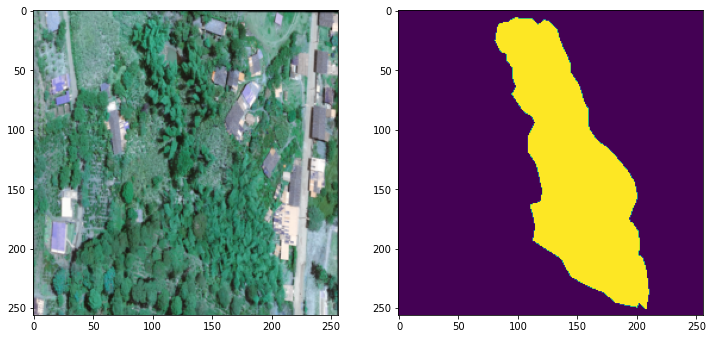

In [10]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [12]:
n_classes = len(np.unique(labels)) # 2 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [14]:
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

In [16]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes)

85521592/85521592 [==============================] - 2s 0us/step


In [17]:
model_resnet_backbone.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

In [18]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [19]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=20,
          verbose=1,
          validation_data=(X_val_prepr, y_val))

Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 0.4718 - iou_score: 0.3767 - val_loss: 0.4927 - val_iou_score: 0.3410
Epoch 2/20
1/1 [==============================] - 0s 292ms/step - loss: 0.4400 - iou_score: 0.4067 - val_loss: 0.5218 - val_iou_score: 0.3143
Epoch 3/20
1/1 [==============================] - 0s 248ms/step - loss: 0.3768 - iou_score: 0.4655 - val_loss: 0.5597 - val_iou_score: 0.2825
Epoch 4/20
1/1 [==============================] - 0s 246ms/step - loss: 0.3352 - iou_score: 0.5092 - val_loss: 0.5912 - val_iou_score: 0.2578
Epoch 5/20
1/1 [==============================] - 0s 288ms/step - loss: 0.3082 - iou_score: 0.5398 - val_loss: 0.6299 - val_iou_score: 0.2296
Epoch 6/20
1/1 [==============================] - 0s 252ms/step - loss: 0.2820 - iou_score: 0.5694 - val_loss: 0.6305 - val_iou_score: 0.2292
Epoch 7/20
1/1 [==============================] - 0s 287ms/step - loss: 0.2636 - iou_score: 0.5914 - val_loss: 0.6087 - val_iou_score: 0.2444
Epoch 8

In [20]:
model_resnet_backbone.save('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf6')

In [21]:
model = load_model('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf6', compile=False)

In [22]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 1s 697ms/step


In [23]:
test_img_number = 0
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 1s 740ms/step


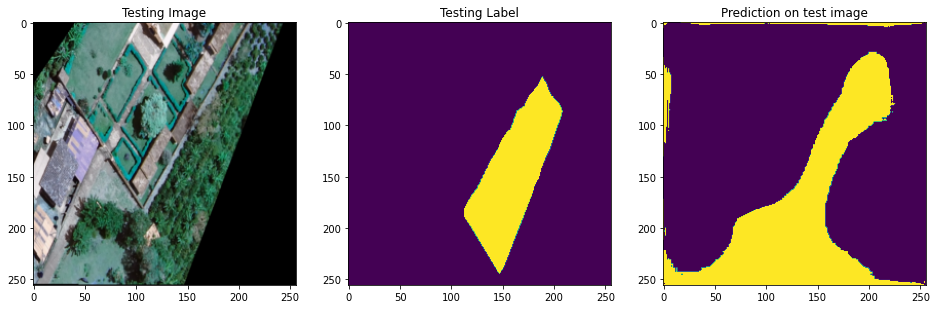

In [24]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [25]:
test_img_number = 3
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 21ms/step


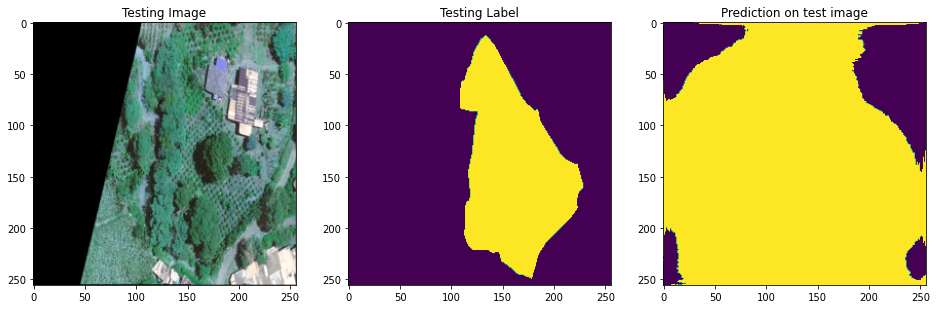

In [26]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

ADDING AUGMENTATION AND RERUN PREDICTION

In [29]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate

import albumentations as A
images_to_generate=600

In [30]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.GridDistortion(p=1)
    ]
)

In [31]:
training_images = glob.glob("/content/gdrive/MyDrive/dataset/image/*.tif")
training_images.sort()

In [32]:
training_mask = glob.glob("/content/gdrive/MyDrive/dataset/mask/*.tif")
training_mask.sort()

In [33]:
images_to_generate=600
i = 1

transformed_images = []
transformed_masks = []
while i<=images_to_generate: 
    number = random.randint(0, len(training_images)-1)  #PIck a number to select an image & mask
    image = training_images[number]
    mask = training_mask[number]
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    
    augmented = aug(image=original_image, mask=original_mask)
    transformed_images.append(augmented['image'])
    transformed_masks.append(augmented['mask'])   
    i =i+1

In [34]:
image_tr_dataset = np.array(transformed_images)

In [35]:
images_concat = np.concatenate((image_dataset, image_tr_dataset), axis=0)

In [36]:
mask_tr_dataset = np.array(transformed_masks)

In [37]:
masks_concat = np.concatenate((mask_dataset, mask_tr_dataset), axis=0)

In [38]:
print("Image data shape is: ", image_tr_dataset.shape)
print("Mask data shape is: ", mask_tr_dataset.shape)
print("Max pixel value in image is: ", image_tr_dataset.max())
print("Labels in the mask are : ", np.unique(mask_tr_dataset))

Image data shape is:  (600, 256, 256, 3)
Mask data shape is:  (600, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1]


In [39]:
sm.set_framework('tf.keras')

In [40]:
masks_concat.shape

(620, 256, 256)

In [41]:
labels = np.expand_dims(masks_concat, axis=3)

In [42]:
labels.shape

(620, 256, 256, 1)

In [43]:
images_concat.shape

(620, 256, 256, 3)

In [44]:
n_classes = len(np.unique(labels)) # 2 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [45]:
labels_cat.shape

(620, 256, 256, 2)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_concat, labels_cat, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [47]:
### Modeling
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [48]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

In [49]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes)

In [50]:
model_resnet_backbone.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score])

In [51]:
model_resnet_backbone.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [52]:

history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=20,
          verbose=1,
          validation_data=(X_val_prepr, y_val))

Epoch 1/20
24/24 [==============================] - 17s 377ms/step - loss: 0.3336 - iou_score: 0.5256 - val_loss: 0.7246 - val_iou_score: 0.1690
Epoch 2/20
24/24 [==============================] - 7s 281ms/step - loss: 0.1893 - iou_score: 0.6965 - val_loss: 0.6961 - val_iou_score: 0.1868
Epoch 3/20
24/24 [==============================] - 7s 278ms/step - loss: 0.1256 - iou_score: 0.7831 - val_loss: 0.3528 - val_iou_score: 0.4850
Epoch 4/20
24/24 [==============================] - 7s 275ms/step - loss: 0.0988 - iou_score: 0.8261 - val_loss: 0.2301 - val_iou_score: 0.6370
Epoch 5/20
24/24 [==============================] - 7s 273ms/step - loss: 0.0761 - iou_score: 0.8615 - val_loss: 0.2420 - val_iou_score: 0.6192
Epoch 6/20
24/24 [==============================] - 7s 272ms/step - loss: 0.0725 - iou_score: 0.8687 - val_loss: 0.2265 - val_iou_score: 0.6438
Epoch 7/20
24/24 [==============================] - 7s 275ms/step - loss: 0.0616 - iou_score: 0.8866 - val_loss: 0.1809 - val_iou_score

In [53]:
# Saving model
model_resnet_backbone.save('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5')

In [54]:
model = load_model('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5', compile=False) # loading model...

In [55]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

4/4 [==============================] - 5s 753ms/step


In [58]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 22ms/step


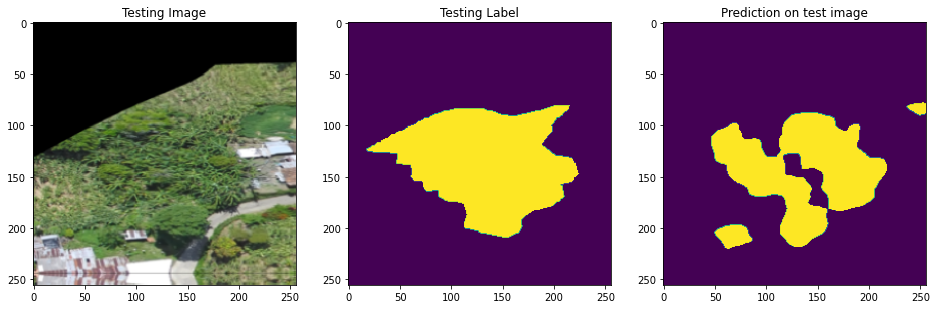

In [59]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [60]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 22ms/step


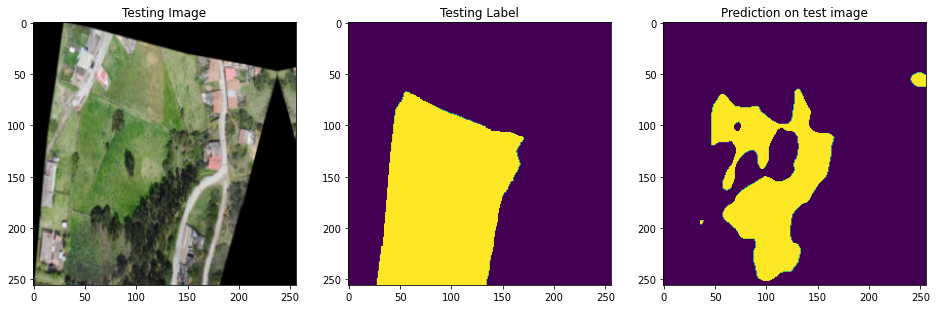

In [61]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [62]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_val_prepr, y_val))

Epoch 1/100
24/24 [==============================] - 7s 281ms/step - loss: 0.0426 - iou_score: 0.9203 - val_loss: 0.1190 - val_iou_score: 0.7900
Epoch 2/100
24/24 [==============================] - 7s 282ms/step - loss: 0.0450 - iou_score: 0.9149 - val_loss: 0.2077 - val_iou_score: 0.6608
Epoch 3/100
24/24 [==============================] - 7s 282ms/step - loss: 0.0382 - iou_score: 0.9273 - val_loss: 0.1199 - val_iou_score: 0.7887
Epoch 4/100
24/24 [==============================] - 7s 281ms/step - loss: 0.0423 - iou_score: 0.9193 - val_loss: 0.1101 - val_iou_score: 0.8038
Epoch 5/100
24/24 [==============================] - 7s 278ms/step - loss: 0.0329 - iou_score: 0.9363 - val_loss: 0.0578 - val_iou_score: 0.8919
Epoch 6/100
24/24 [==============================] - 7s 277ms/step - loss: 0.0448 - iou_score: 0.9156 - val_loss: 0.1199 - val_iou_score: 0.7908
Epoch 7/100
24/24 [==============================] - 7s 272ms/step - loss: 0.0319 - iou_score: 0.9373 - val_loss: 0.0828 - val_iou

In [63]:
model_resnet_backbone.save('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5')

In [64]:
model = load_model('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5', compile=False)

In [65]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

4/4 [==============================] - 1s 143ms/step


In [66]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 53ms/step


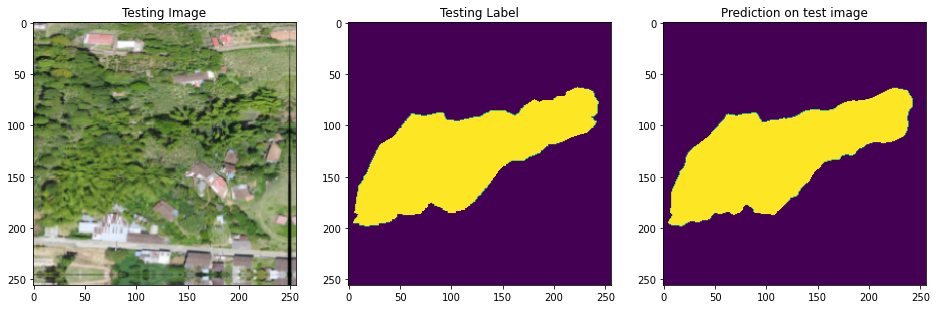

In [67]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [68]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 53ms/step


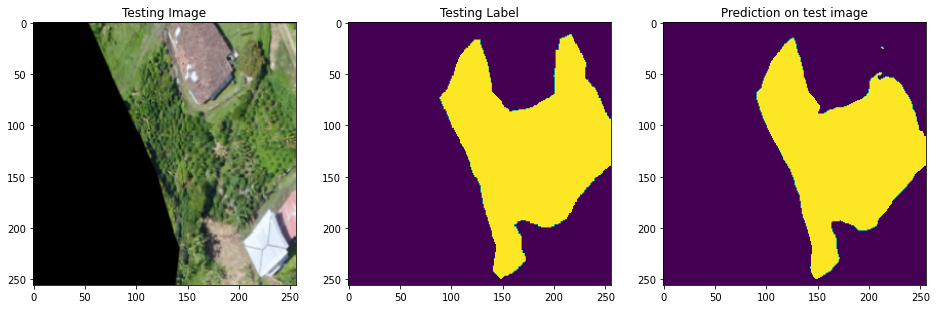

In [69]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()